In [1]:
import torch
import matplotlib.pyplot as plt
from torch import optim, distributions, nn
from tqdm.notebook import tqdm
import gpzoo
from gpzoo.gp import MGGP_SVGP
from gpzoo.kernels import MGGP_NSF_RBF
from gpzoo.likelihoods import NSF2
from gpzoo.utilities import train_hybrid, train_hybrid_batched, anndata_to_train_val
import squidpy as sq
import numpy as np
from sklearn.decomposition import NMF
import scanpy as sc
import random

from gpzoo.utilities import regularized_nmf, dims_autocorr
from matplotlib.animation import FuncAnimation
from matplotlib import animation
import pickle

/gladstone/engelhardt/home/lchumpitaz/gitclones/GPzoo/gpzoo/utilities.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/nsf/lib/python3.9/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/nsf/lib/python3.9/site-packages/spatialdata/__init__.py:9: UserWarning: Geopandas was set to use PyGEOS, changing to shapely 2.0 with:

	geopandas.options.use_pygeos = True

If you intended to use PyGEOS, set the option to False.
  _check_geopandas_using_shapely()


In [2]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=1)

In [3]:
new_model=True

In [4]:
adata = sq.datasets.slideseqv2()
adata = adata.raw.to_adata()

In [5]:
adata.var["mt"] = adata.var_names.str.startswith("mt-")

In [6]:
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

<Axes: >

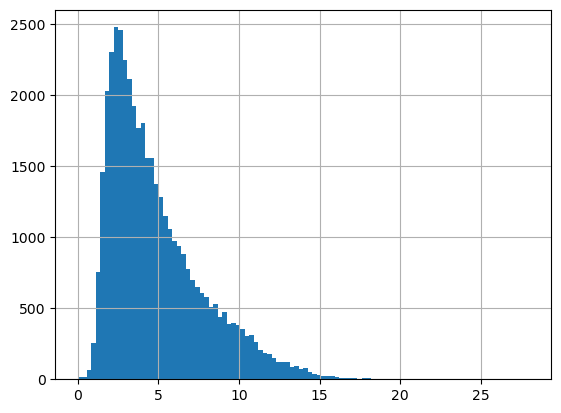

In [7]:
adata.obs.pct_counts_mt.hist(bins=100)

In [8]:
adata = adata[adata.obs.pct_counts_mt < 20] #from 53K to 45K

In [9]:
sc.pp.filter_cells(adata, min_counts=100)

/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/nsf/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_counts'] = number


In [10]:
sc.pp.filter_genes(adata, min_cells=1)

In [11]:
idx = list(range(adata.shape[0]))
random.shuffle(idx)
adata = adata[idx]

In [12]:
Dtr, Dval = anndata_to_train_val(adata, sz="scanpy")

In [13]:
# Y_sums = np.array(np.sum(adata.X > 0, axis=0))[0]

# Y_nsf = np.array(adata.X[:, Y_sums>100].todense() * 100, dtype=int).T
# Y = np.array(adata.X[:].todense()*100, dtype=int).T

In [14]:
Y = Dtr['Y'].T

In [15]:
X = Dtr['X']*50.0

/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/nsf/lib/python3.9/site-packages/squidpy/pl/_color_utils.py:26: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  target.uns[color_key] = source.uns[color_key]
/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/nsf/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:956: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


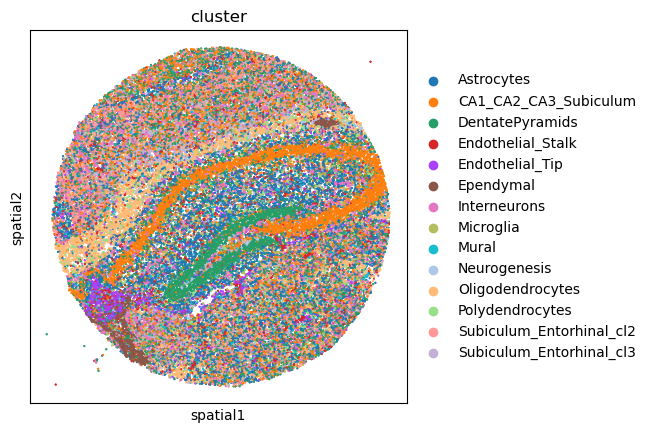

In [16]:
sq.pl.spatial_scatter(adata, color="cluster", size=1, shape=None)

# plt.figure(figsize=(10, 10))
# for i, category in enumerate(adata.obs.cluster.values.categories):
#     mask = adata.obs.cluster.values==category
#     plt.subplot(4, 4, i+1)
#     plt.title(category, fontsize=8)
#     plt.scatter(adata.obs.x[mask], adata.obs.y[mask], alpha=0.1, s=2)
#     plt.xlim([0, 6000])
#     plt.ylim([0, 6000])
#     plt.gca().invert_yaxis()
#     plt.xticks([])
#     plt.yticks([])

In [17]:
# factors, loadings = regularized_nmf(Y.T, L=20, shrinkage=0.3, max_iter = 40, solver='mu', init='nndsvdar', beta_loss='kullback-leibler', random_state=12)

In [18]:
# moran_idx, moranI = dims_autocorr(np.exp(factors), X)

In [19]:
# factors_ordered = factors[:, moran_idx]
# loadings_ordered = loadings[:, moran_idx]

In [20]:
X = torch.tensor(X, dtype=torch.float)
Y = torch.tensor(Y, dtype=torch.float)

In [21]:
L = 20
M = 215



groupsX = torch.tensor(adata[Dtr['idx']].obs.cluster.values.codes).type(torch.LongTensor)
n_groups = len(adata.obs.cluster.values.categories)

idx = torch.multinomial(torch.ones(X.shape[0]), num_samples=n_groups*M, replacement=False)



kernel = MGGP_NSF_RBF(L=L, sigma=1.0, lengthscale=1.5, n_groups=n_groups, group_diff_param=2.0)
gp = MGGP_SVGP(kernel, M=M, n_groups=n_groups, jitter=1e-1)

gp.Lu = nn.Parameter(torch.eye(n_groups*M).expand(L, n_groups*M, n_groups*M).clone())
gp.mu = nn.Parameter(torch.randn((L, n_groups*M)))
gp.Z = nn.Parameter(torch.tensor(X[idx]), requires_grad=False)
gp.groupsZ = nn.Parameter(groupsX[idx].type(torch.LongTensor), requires_grad=False)

model = NSF2(gp, Y, L=L)


if not new_model:
    model.load_state_dict(torch.load('slideseq_mggp_nsf.pth'))
    
    with open("slideseq_mggp_nsf_means.pth", "rb") as fp:   
        means = pickle.load(fp)

    with open("slideseq_mggp_nsf_scales.pth", "rb") as fp:   
        scales = pickle.load(fp)

    with open("slideseq_mggp_nsf_idxs.pth", "rb") as fp:   
        idxs = pickle.load(fp)
        

model.to(device)

/tmp/ipykernel_1438888/2190617505.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp.Z = nn.Parameter(torch.tensor(X[idx]), requires_grad=False)


NSF2(
  (prior): MGGP_SVGP(
    (kernel): MGGP_NSF_RBF()
  )
)

In [22]:
def train_batched(model, optimizer, X, groupsX, y, device, steps=200, E=20, batch_size=1000, **kwargs):
    losses = []
    
    means = []
    scales = []
    idxs = []
    
    for it in tqdm(range(steps)):
        
        idx = torch.multinomial(torch.ones(X.shape[0]), num_samples=batch_size, replacement=False)
        
        
        optimizer.zero_grad()
        pY, qF, qU, pU = model.forward_batched(X=X, idx=idx, E=E, groupsX=groupsX[idx], **kwargs)

        logpY = y[:, idx]*torch.log(pY.rate) - pY.rate

        ELBO = (logpY).mean(axis=0).sum()
        ELBO -= torch.sum(distributions.kl_divergence(qU, pU))

        loss = -ELBO
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        if (it%10)==0:
            idxs.append(idx.detach().cpu().numpy())
            means.append(torch.exp(qF.mean.detach().cpu()).numpy())
            scales.append(qF.scale.detach().cpu().numpy())
    
    with torch.no_grad():
        if device.type=='cuda':
            torch.cuda.empty_cache()
        
    return losses, means, scales, idxs

In [23]:
# def train(model, optimizer, X, y, device, steps=200, E=20, **kwargs):
#     losses = []
    
#     means = []
#     scales = []
    
#     for it in tqdm(range(steps)):
        
#         optimizer.zero_grad()
#         pY, qF, qU, pU = model.forward(X=X, E=E, **kwargs)

#         logpY = y*torch.log(pY.rate) - pY.rate

#         ELBO = (logpY).mean(axis=0).sum()
#         ELBO -= torch.sum(distributions.kl_divergence(qU, pU))

#         loss = -ELBO
#         loss.backward()
#         optimizer.step()

#         losses.append(loss.item())
#         if (it%10)==0:
#             means.append(torch.exp(qF.mean.detach().cpu()).numpy())
#             scales.append(qF.scale.detach().cpu().numpy())
    
#     with torch.no_grad():
#         if device.type=='cuda':
#             torch.cuda.empty_cache()
        
#     return losses, means, scales

In [24]:
X_train = X.to(device)
Y_train = Y.to(device)
groupsX_train = groupsX.to(device)

In [49]:
# model.prior.kernel.lengthscale = nn.Parameter(torch.ones_like(model.prior.kernel.lengthscale)*1.1)

In [50]:
model.prior.kernel.lengthscale.requires_grad = False
model.prior.kernel.sigma.requires_grad = False
model.prior.kernel.group_diff_param.requires_grad = False
model.prior.Z.requires_grad=False
model.prior.mu.requires_grad=True
model.prior.Lu.requires_grad=True

In [51]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

In [30]:
model.to(device)
losses, means, scales, idxs = train_batched(model, optimizer, X_train, groupsX_train, Y_train, device, steps=5*2000, E=1, batch_size=7000)

  0%|          | 0/10000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [29]:
# torch.save(model.state_dict(), 'slideseq_nsf.pth')
# with open("slideseq_nsf_means.pth", "wb") as fp:   
#     pickle.dump(means, fp)

# with open("slideseq_nsf_scales.pth", "wb") as fp:   
#     pickle.dump(scales, fp)

# with open("slideseq_nsf_idxs.pth", "wb") as fp:   
#     pickle.dump(idxs, fp)

In [53]:
model.to(device)
losses, means2, scales2, idxs2 = train_batched(model, optimizer, X_train, groupsX_train, Y_train, device, steps=1000, E=1, batch_size=7000)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [52]:
# means = means + means2
# scales = scales + scales2
# idxs = idxs + idxs2

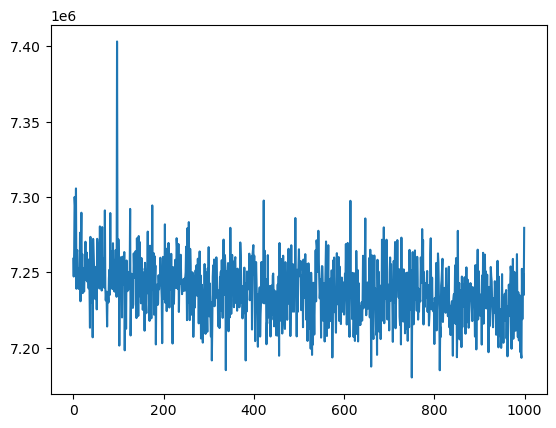

In [54]:
plt.plot(losses);

In [55]:
model.cpu()

qF, qU, pU = model.prior(X, groupsX=groupsX)

factors = torch.exp(qF.mean).detach().cpu().numpy()
factors_scales = torch.nn.functional.softplus(qF.scale.detach().cpu()).numpy()


del qF, pU, qU

In [56]:
moran_idx, moranI = dims_autocorr(factors.T, X)

In [57]:
def plot(factors, moran_idx, ax=None, size=7, alpha=0.8):
    
    max_val = np.percentile(factors, 99)
    min_val = np.percentile(factors, 1)

    if ax is None:
        fig, ax = plt.subplots(4, 5, figsize=(size*5, size*4), tight_layout=True)
        
    for i in range(L):
        plt.subplot(L//5, 5, i+1)
        
        curr_ax = ax[i//5, i%5]
        
        curr_ax.scatter(X[:, 0], X[:,1], c=factors[moran_idx][i], vmin=min_val, vmax=max_val, alpha=alpha, cmap='turbo', s=0.1)

        curr_ax.invert_yaxis()
        curr_ax.set_xticks([])
        curr_ax.set_yticks([])
        curr_ax.set_facecolor('xkcd:gray')

In [58]:
def plot2(factors, moran_idx, idx, ax=None, size=7, alpha=0.8):
    
    max_val = np.percentile(factors, 99)
    min_val = np.percentile(factors, 1)

    if ax is None:
        fig, ax = plt.subplots(4, 5, figsize=(size*5, size*4), tight_layout=True)
        
    for i in range(L):
        plt.subplot(L//5, 5, i+1)
        
        curr_ax = ax[i//5, i%5]
        
        curr_ax.scatter(X[idx, 0], X[idx,1], c=factors[moran_idx][i], vmin=min_val, vmax=max_val, alpha=alpha, cmap='turbo', s=0.1)
        
        curr_ax.set_xlim([X[:,0].min()*1.1, X[:,0].max()*1.1])
        curr_ax.set_ylim([X[:,1].min()*1.1, X[:,1].max()*1.1])
        curr_ax.invert_yaxis()
        curr_ax.set_xticks([])
        curr_ax.set_yticks([])
        curr_ax.set_facecolor('xkcd:gray')

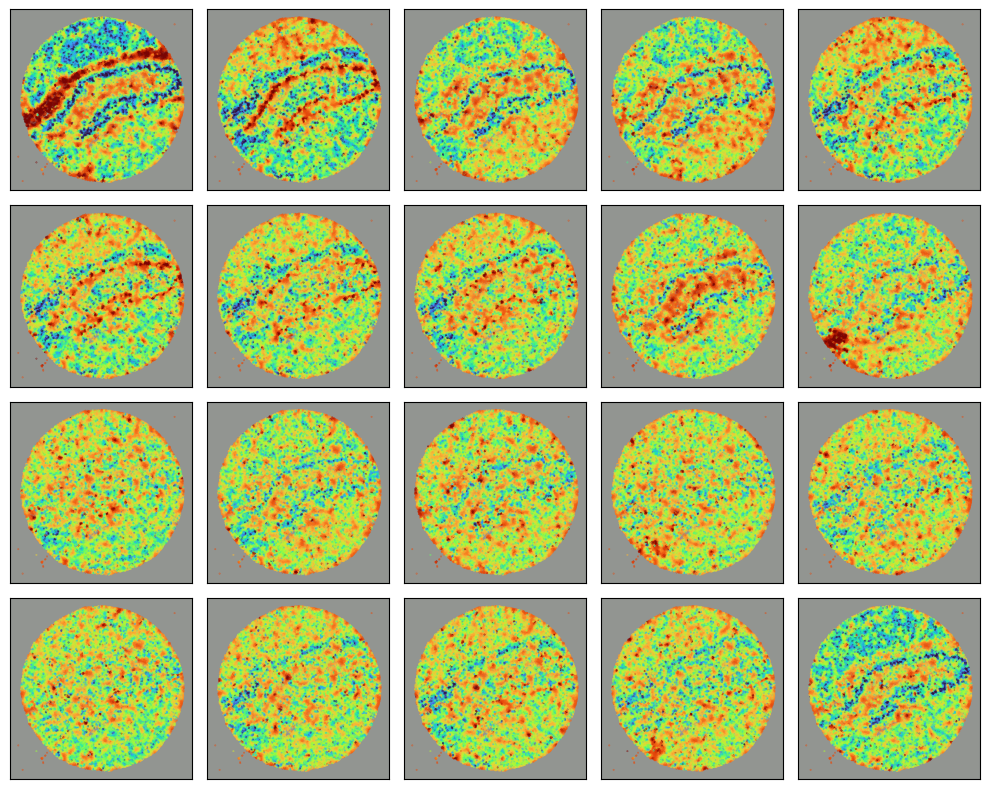

In [59]:
plot(factors, moran_idx, size=2, alpha=0.8)

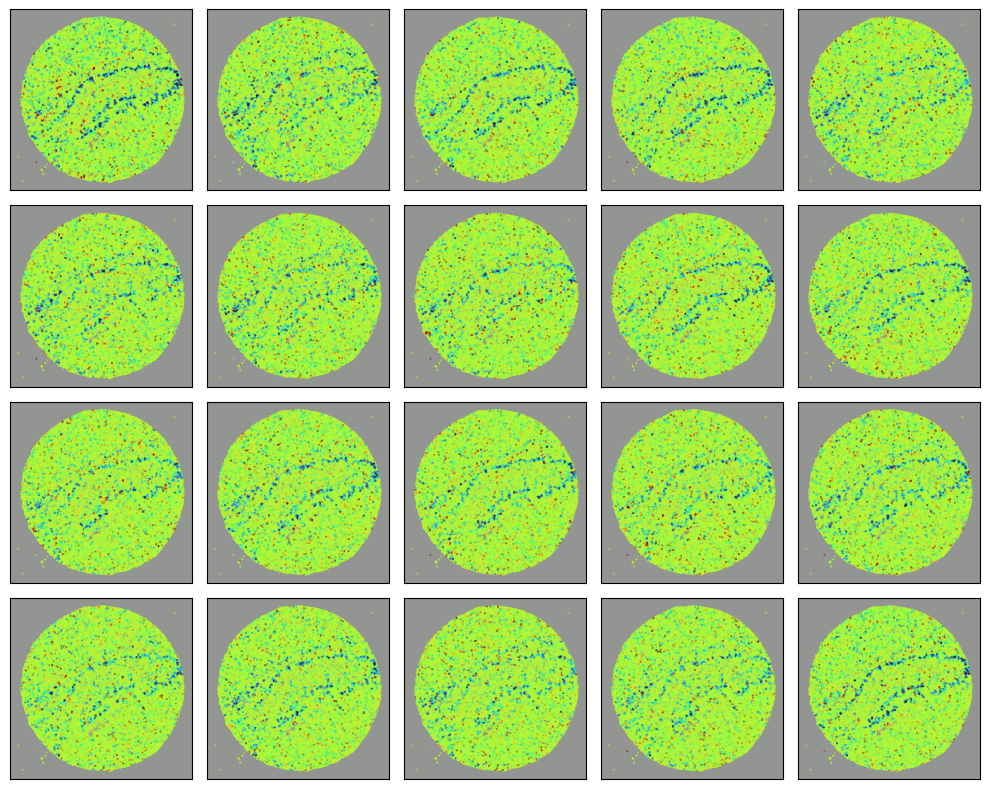

In [60]:
plot(factors_scales, moran_idx, size=2, alpha=0.8)

hi 0
hi 0
hi 35
hi 70
hi 105
hi 140
hi 175
hi 210
hi 245
hi 280
hi 315
hi 350
hi 385
hi 420
hi 455
hi 490
hi 525
hi 560
hi 595
hi 630
hi 665
hi 700
hi 735
hi 770
hi 805
hi 840
hi 875
hi 910
hi 945
hi 980
hi 1015
hi 1050
hi 1085
hi 1120
hi 1155
hi 1190
hi 1225
hi 1260
hi 1295
hi 1330
hi 1365
hi 1400
hi 1435
hi 1470
hi 1505
hi 1540
hi 1575
hi 1610
hi 1645
hi 1680
hi 1715
hi 1750
hi 1785
hi 1820
hi 1855
hi 1890
hi 1925
hi 1960
hi 1995
hi 2030
hi 2065
hi 2100
hi 2135
hi 2170
hi 2205
hi 2240
hi 2275
hi 2310
hi 2345
hi 2380
hi 2415
hi 2450
hi 2485
hi 2520
hi 2555
hi 2590
hi 2625
hi 2660
hi 2695
hi 2730
hi 2765
hi 2800
hi 2835
hi 2870
hi 2905
hi 2940
hi 2975
hi 3010
hi 3045
hi 3080
hi 3115
hi 3150
hi 3185
hi 3220
hi 3255
hi 3290
hi 3325
hi 3360
hi 3395
hi 3430
hi 3465


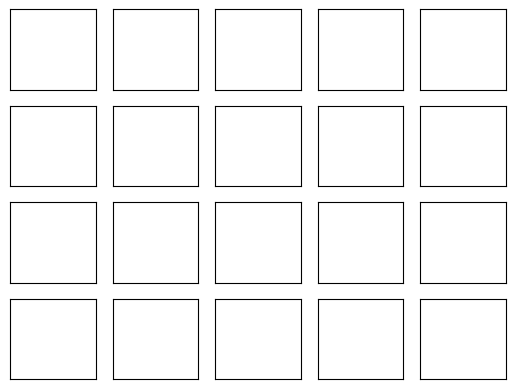

In [73]:
size=7
fig, ax = plt.subplots(4, 5, figsize=(size*5, size*4), tight_layout=True)


def update(iteration):
    for ax_row in ax:
        for element in ax_row:
            element.cla()
            
    
    curr_mean = means[iteration]
    curr_idx = idxs[iteration]
    
    
    plot2(curr_mean, moran_idx, curr_idx, ax=ax, size=7, alpha=0.8)
#     fig.suptitle(f"Iteration: {iteration}, Loss: {losses[iteration*10]:0.2f}")
#     fig.tight_layout()
    print('hi', iteration)
    


anim = FuncAnimation(fig, update, frames=np.arange(0, len(means), 35), interval=100)
plt.close()

# anim.save('pnmf.mp4',
#          writer=animation.FFMpegWriter(fps=50, bitrate=2000, codec='h264'),
#          dpi=50)
anim.save("slideseq_nsf_means.mp4", fps=10, dpi=50)

hi 0
hi 0
hi 35
hi 70
hi 105
hi 140
hi 175
hi 210
hi 245
hi 280
hi 315
hi 350
hi 385
hi 420
hi 455
hi 490
hi 525
hi 560
hi 595
hi 630
hi 665
hi 700
hi 735
hi 770
hi 805
hi 840
hi 875
hi 910
hi 945
hi 980
hi 1015
hi 1050
hi 1085
hi 1120
hi 1155
hi 1190
hi 1225
hi 1260
hi 1295
hi 1330
hi 1365
hi 1400
hi 1435
hi 1470
hi 1505
hi 1540
hi 1575
hi 1610
hi 1645
hi 1680
hi 1715
hi 1750
hi 1785
hi 1820
hi 1855
hi 1890
hi 1925
hi 1960
hi 1995
hi 2030
hi 2065
hi 2100
hi 2135
hi 2170
hi 2205
hi 2240
hi 2275
hi 2310
hi 2345
hi 2380
hi 2415
hi 2450
hi 2485
hi 2520
hi 2555
hi 2590
hi 2625
hi 2660
hi 2695
hi 2730
hi 2765
hi 2800
hi 2835
hi 2870
hi 2905
hi 2940
hi 2975
hi 3010
hi 3045
hi 3080
hi 3115
hi 3150
hi 3185
hi 3220
hi 3255
hi 3290
hi 3325
hi 3360
hi 3395
hi 3430
hi 3465


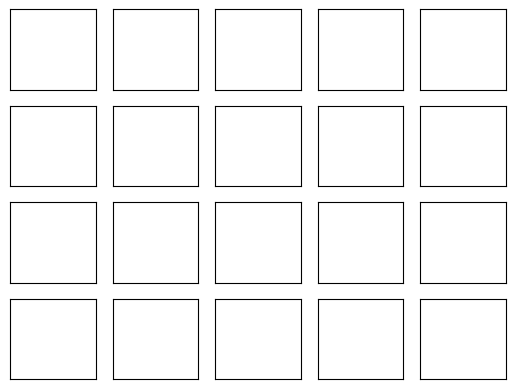

In [74]:
size=7
fig, ax = plt.subplots(4, 5, figsize=(size*5, size*4), tight_layout=True)


def update(iteration):
    for ax_row in ax:
        for element in ax_row:
            element.cla()
            
    
    curr_scale = scales[iteration]
    curr_idx = idxs[iteration]
    
    
    plot2(curr_scale, moran_idx, curr_idx, ax=ax, size=7, alpha=0.8)
#     fig.suptitle(f"Iteration: {iteration}, Loss: {losses[iteration*10]:0.2f}")
#     fig.tight_layout()
    print('hi', iteration)


anim = FuncAnimation(fig, update, frames=np.arange(0, len(means), 35), interval=100)
plt.close()
# anim.save('pnmf.mp4',
#          writer=animation.FFMpegWriter(fps=50, bitrate=2000, codec='h264'),
#          dpi=50)
anim.save("slideseq_nsf_scales.mp4", fps=10, dpi=50)